In [6]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [7]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [8]:
df = process_experiment(
    r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Feb10-230339_configs"
)
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'estimator.args_.lin_hidden_out_size', 'seed',
       'experiment_name'],
      dtype='object')

In [9]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,...,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,estimator.args_.lin_hidden_out_size,seed,experiment_name
0,training,200000,-1214.490778,-15.591268,-22.659766,-22.210309,19.506593,26,5151,35.647059,...,0.012632,-0.682432,-0.456740,0.517840,48749.0,48.0,0 days 00:02:44.687380,32,0,0000_estimator.args_.lin_hidden_out_size_32
1,training,400000,-23.767943,-21.696735,-22.693724,-22.760015,0.262139,35,39,36.745545,...,-0.228129,-0.688645,-0.459559,0.527915,50000.0,48.0,0 days 00:03:51.487138,32,0,0000_estimator.args_.lin_hidden_out_size_32
2,training,600000,-22.273947,-21.661265,-21.913076,-21.835230,0.197912,35,36,35.300035,...,-0.214455,-0.680407,-0.436012,0.551915,50000.0,52.0,0 days 00:03:54.787957,32,0,0000_estimator.args_.lin_hidden_out_size_32
3,training,800000,-21.689526,-21.136885,-21.335028,-21.294687,0.152287,34,35,34.157814,...,-0.215851,-0.696157,-0.432766,0.573581,50000.0,48.0,0 days 00:03:47.025832,32,0,0000_estimator.args_.lin_hidden_out_size_32
4,training,1000000,-21.171610,-20.666353,-20.838467,-20.799494,0.142908,33,34,33.160836,...,-0.216065,-0.715720,-0.451081,0.594712,50000.0,52.0,0 days 00:03:52.723862,32,0,0000_estimator.args_.lin_hidden_out_size_32
5,training,1200000,-20.676089,-20.277224,-20.395477,-20.336946,0.122025,32,33,32.216978,...,-0.217619,-0.734255,-0.451763,0.612083,50000.0,48.0,0 days 00:03:53.782117,32,0,0000_estimator.args_.lin_hidden_out_size_32
6,training,1400000,-20.358585,-20.242295,-20.296958,-20.290077,0.023541,32,32,32.000000,...,-0.220056,-0.753967,-0.469583,0.627147,50000.0,52.0,0 days 00:03:55.793665,32,0,0000_estimator.args_.lin_hidden_out_size_32
7,training,1600000,-20.364145,-20.176259,-20.250378,-20.247701,0.031746,32,32,32.000000,...,-0.197267,-0.763918,-0.477766,0.642246,50000.0,48.0,0 days 00:03:47.011835,32,0,0000_estimator.args_.lin_hidden_out_size_32
8,training,1800000,-20.221950,-20.126201,-20.176484,-20.175318,0.016057,32,32,32.000000,...,-0.226160,-0.770602,-0.484161,0.656565,50000.0,52.0,0 days 00:03:46.590300,32,0,0000_estimator.args_.lin_hidden_out_size_32
9,training,2000000,-583.608042,-20.120518,-20.880910,-20.534747,7.208665,32,307,32.474103,...,-0.142111,-0.776937,-0.476722,0.684021,50000.0,48.0,0 days 00:03:44.094520,32,0,0000_estimator.args_.lin_hidden_out_size_32


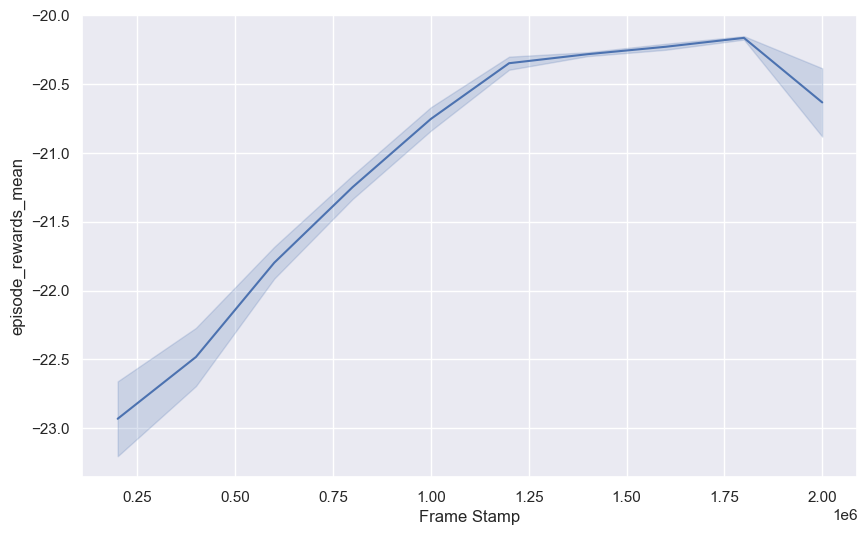

In [10]:

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()